# Traffic Sign Recognition Classifier

## Project within the Self-Driving Car Engineer Nanodegree: Deep Learning

### Work in progress: Stand 4/11/2017

The template for this project can be found at [Udacity's github account](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project). The [data](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip) used in this project is a pre-processed version of the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The project **should** full-fill all points of the project's [rubric](https://review.udacity.com/#!/rubrics/481/view) and includes also **0** of the stand-out suggestions.

This notebook is a modified version of the above template.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

---
## Step 0: Load The Data

In [1]:
# Load some basic libraries
import numpy as np # Efficient numerical arrays
import pandas as pd # Time series analysis
import matplotlib.pyplot as plt # Visulisation
%matplotlib inline
import cv2

In [2]:
# Load pickled data
import pickle

training_file = "../train.p"
validation_file = "../valid.p"
testing_file = "../test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

signnames = pd.read_csv(signnames_file)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

# shape of an traffic sign image
image_shape = X_train.shape[1:]

# unique classes/labels
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

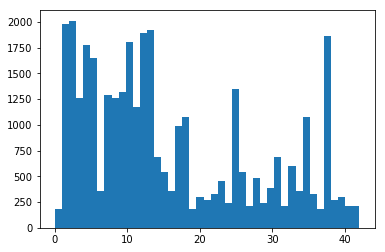

In [4]:
#Fast visualisation of label distribution
n, bins, patches = plt.hist(y_train, bins=n_classes)

In [5]:
# Add the values to the signnames dataframe to do more stuff
signnames['Amount'] = n
signnames['Percentage'] = n / n_train * 100

sorted_signnames = signnames.sort_values(by=['Percentage'], ascending=False)

from IPython.display import display
print('Classes ordered by their frequency in the data set')
display(sorted_signnames)

Classes ordered by their frequency in the data set


,ClassId,SignName,Amount,Percentage
2,2,Speed limit (50km/h),2010.0,5.776028
1,1,Speed limit (30km/h),1980.0,5.689819
13,13,Yield,1920.0,5.517400
12,12,Priority road,1890.0,5.431191
38,38,Keep right,1860.0,5.344981
10,10,No passing for vehicles over 3.5 metric tons,1800.0,5.172562
4,4,Speed limit (70km/h),1770.0,5.086353
5,5,Speed limit (80km/h),1650.0,4.741516
25,25,Road work,1350.0,3.879422
9,9,No passing,1320.0,3.793212


In [6]:
print(X_train[0].max())
print(X_train[0].min())

113
19


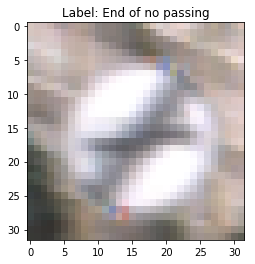

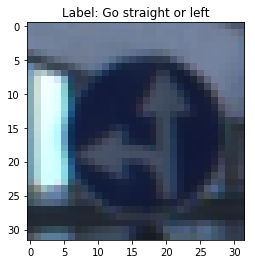

In [7]:
def signname(index, y_data=y_train):
    return signnames['SignName'].values[y_data[index]]

def plot_training_image(index):
    plt.figure()
    label = signnames
    plt.title('Label: {}'.format(signname(index)))
    plt.imshow(X_train[index])
    plt.show()

# Plot two examples
plot_training_image(50)
plot_training_image(5000)

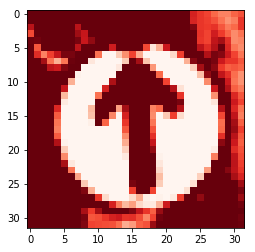

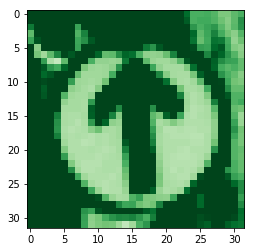

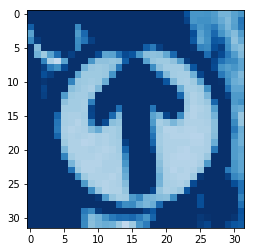

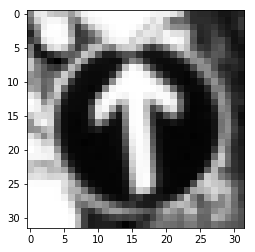

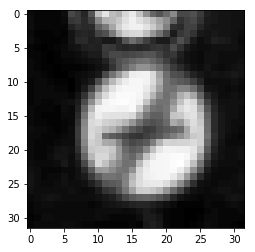

In [8]:
# Do some tests
testimg = X_train[20000]
testarr = X_train[0:5]
#print(testimg)

# Colour thresholding
#blue = testimg[:,:,2]
#blue = blue[blue>200]

plt.figure()
plt.imshow(testimg[:,:,0], cmap='Reds', vmin=50, vmax=128)
plt.figure()
plt.imshow(testimg[:,:,1], cmap='Greens', vmin=50, vmax=128)
plt.figure()
plt.imshow(testimg[:,:,1], cmap='Blues', vmin=50, vmax=128)

testarrnew = []
testimg = cv2.cvtColor(testimg, cv2.COLOR_RGB2GRAY)
testarrnew.append(cv2.cvtColor(testarr[0], cv2.COLOR_RGB2GRAY))

plt.figure()
plt.imshow(testimg, cmap='Greys_r')
plt.figure()
plt.imshow(testarrnew[0], cmap='Greys_r')
#print(testimg)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

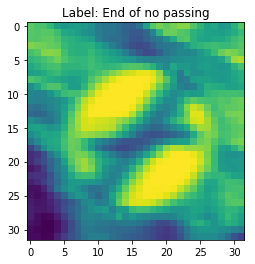

In [9]:
import cv2

# Normalization
def MinMaxScaler( data, max=255, min=0): #Images values have range 0-255
    return (data - min) / (max - min)

# Standardization
def Standardiser(data):
    return (data - np.array(data).mean()) / np.array(data).std()

# Data stretching = cutoff of noise/outliers
def Stretching(data):
    pass

# Colour Transformations
def Grayscale(data):
    ''' Does it need to be in another layer?'''
    data_new = []
    for i in range(len(data)):
         data_new.append(cv2.cvtColor( data[i], cv2.COLOR_RGB2GRAY))
    data_new = np.array(data_new)
    data_new.reshape(-1,32,32,1)
    return data_new

def ColourThreshold(data):
    ''' For colour (rgb) images only '''
    pass
    # Idea... add another layer e.g. red, green, blue and grayscale
    # Red and blue should be strongly thresholded since traffic signs are mainly these colours

# Combined pipleine for pre-processing
def preprocessing(data):
    data = Grayscale(data)
    #data = MinMaxScaler(data)
    data = Standardiser(data)
    return data



X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

# Check the outcome
plot_training_image(50)


In [10]:
# Check the shape of the input after preprocessing
print(X_train.shape)

try:
    input_depth = X_train.shape[3]
except:
    print('Preprocessing resulted in incompatible data format')

    try:
        X_train = X_train.reshape(len(X_train),32,32,1)
        input_depth = X_train.shape[3]
        
        X_valid = X_valid.reshape(len(X_valid),32,32,1)
        X_test = X_test.reshape(len(X_test),32,32,1)
        print('Succesfully reshaped to {}'.format(X_train.shape))
    except:
        pass

(34799, 32, 32)
Preprocessing resulted in incompatible data format
Succesfully reshaped to (34799, 32, 32, 1)


### Model Architecture
Start based on the LeNet Architecture

* Layer 1: Convolutional. The output shape should be 28x28x6.

* Activation. Your choice of activation function.

* Pooling. The output shape should be 14x14x6.

* Layer 2: Convolutional. The output shape should be 10x10x16.

* Activation. Your choice of activation function.

* Pooling. The output shape should be 5x5x16.

* Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

* Layer 3: Fully Connected. This should have 120 outputs.

* Activation. Your choice of activation function.

* Layer 4: Fully Connected. This should have 84 outputs.

* Activation. Your choice of activation function.

* Layer 5: Fully Connected (Logits). This should have 43 outputs.


In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def ConvNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 29x29x6.
    W1 = tf.Variable(tf.truncated_normal((4,4,input_depth,6), mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b1)

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Layer1.2 : Convolutional. Input 29x29x6. Output 28x28x12
    W11 = tf.Variable(tf.truncated_normal((2,2,6,12), mean=mu, stddev=sigma))
    b11 = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(conv1, W11, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b11)

    # Activation.
    conv1 = tf.nn.relu(conv1)    
    
    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x12. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal((5,5,12,16), mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, W2, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, b2)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal((400,120), mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(conv2, W3), b3)
    
    # Activation.
    layer3 = tf.nn.relu(layer3)

    # Dropout to prevent overfitting
#    fc1 = tf.nn.dropout(layer3, DROPOUT)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal((120,84), mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3, W4), b4)
    
    # Activation.
    layer4 = tf.nn.relu(layer4)

    # Layer 5: Fully Connected. Input = 84. Output = 43 (n_classes).
    W5 = tf.Variable(tf.truncated_normal((84,n_classes), mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(layer4, W5), b5)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
# Hyperparameters
RATE = 0.0005
EPOCHS = 10
BATCH_SIZE = 128
#DROPOUT = 0.75

# Placeholders for one batch of images and labels
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
#keep_prob = tf.placeholder(tf.float32)

### Training pipeline

In [13]:
logits = ConvNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation pipeline

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})#, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



### Train the model
The model is learning by running the training though the training pipline. Then the loss and accuracy is analysed by using the model to predict the validation data. This information is used to improve the model by backpropagation (stochastic gradient descent). These steps are repeated for xx epochs.
In the end, the model is saved.

In [15]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})#, keep_prob: DROPOUT})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './convnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.666

EPOCH 2 ...
Validation Accuracy = 0.834

EPOCH 3 ...
Validation Accuracy = 0.865

EPOCH 4 ...
Validation Accuracy = 0.892

EPOCH 5 ...
Validation Accuracy = 0.901

EPOCH 6 ...
Validation Accuracy = 0.901

EPOCH 7 ...
Validation Accuracy = 0.908

EPOCH 8 ...
Validation Accuracy = 0.914

EPOCH 9 ...
Validation Accuracy = 0.921

EPOCH 10 ...
Validation Accuracy = 0.912

Model saved


### Evaluate the model with the test data
When the model is ready, the accuracy can be measured with the test data set. That step should be performed only once in order to keep the test data and model completley independent.

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.905


---

## Step 3: Test a Model on New Images

To check how the model is working, several traffic sign images were downloaded from the internet. The label (=class id) were assigned according to `signnames.csv`. The test images were chosen such that an image of the class with the most train images and an image of the class with the fewest train images is present. Also a partly modified image was chosen to check how the model can adapt.

### Load and Output the Images

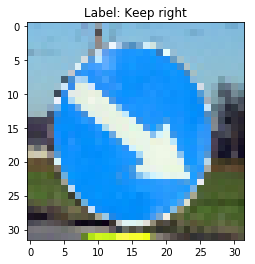

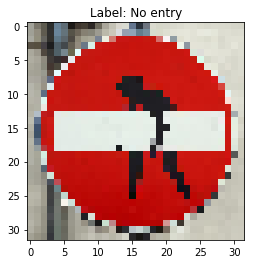

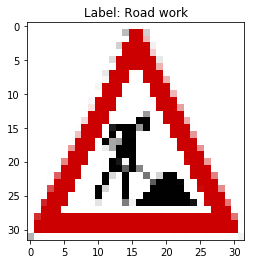

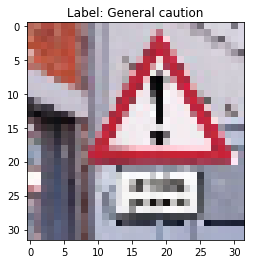

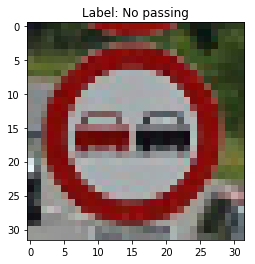

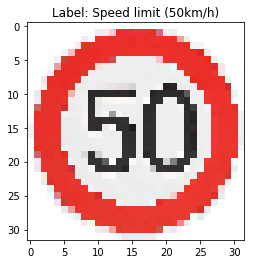

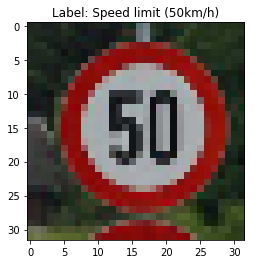

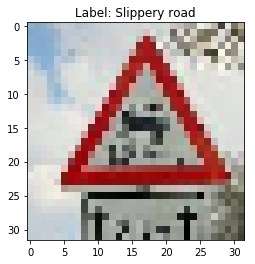

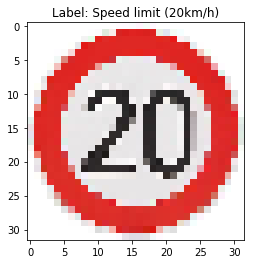

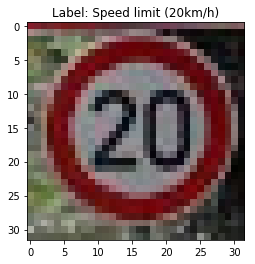

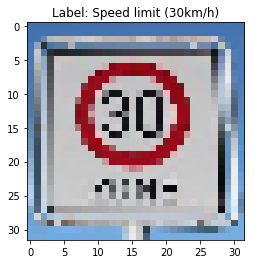

In [30]:
pic_dir = "test_images"
import os
pic_path = os.listdir(pic_dir)
pic_label = [38, 17, 25, 18, 9, 2, 2, 23, 0, 0, 1]
#pic_path = ["test_images/speed_limit_50_photo.jpg", "test_images/speed_limit_50.jpg", "test_images/no_passing.jpg",
#            "test_images/speed_limit_20_2.jpg", "test_images/no_entry_modified.jpg"]
#pic_label = [2, 2, 9, 0, 17]

def load_and_plot_image(img_id):
    pic = plt.imread(os.path.join(pic_dir,pic_path[img_id]))
    pic = cv2.resize(pic, (32, 32))
    plt.figure()
    #plt.subplot(5,2, img_id+1)
    plt.imshow(pic)
    plt.title('Label: {}'.format(signnames['SignName'].values[pic_label[img_id]]))
    return pic

pics = []
#plt.figure(10)
for i in range(len(pic_label)):
    pics.append(load_and_plot_image(i))

#plt.figure()
#plt.subplot(2,1,1)
#plt.imshow(pics[0])
#plt.subplot(2,2,1)
#plt.imshow(pics[1])

### Predict the Sign Type for Each Image

In [31]:
X_new = pics

y_new = pic_label
X_new = preprocessing(X_new)
X_new = X_new.reshape(-1,32,32,1)

pred = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predictions = sess.run(pred, feed_dict={x: X_new})
    top_pred = sess.run(tf.nn.top_k(tf.constant(predictions), k=5))
    #print(top_pred)

### Visualization of the Softmax probabilites of every image

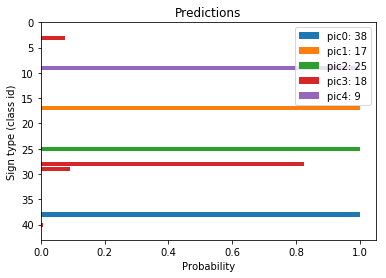

In [32]:
label_id = np.arange(0,n_classes,1)[::-1]
plt.figure()
plt.title("Predictions")
plt.barh(label_id, predictions[0][::-1], label='pic0: {}'.format(pic_label[0]))
plt.barh(label_id, predictions[1][::-1], label='pic1: {}'.format(pic_label[1]))
plt.barh(label_id, predictions[2][::-1], label='pic2: {}'.format(pic_label[2]))
plt.barh(label_id, predictions[3][::-1], label='pic3: {}'.format(pic_label[3]))
plt.barh(label_id, predictions[4][::-1], label='pic4: {}'.format(pic_label[4]))
plt.ylabel('Sign type (class id)')
plt.xlabel('Probability')
plt.ylim(n_classes,0)
plt.legend()

### Analyze Performance

In [34]:
for img_id in range(len(pic_label)):
    pred_tmp = signnames['SignName'].values[top_pred[1][img_id][0]]
    val = 100*top_pred[0][img_id][0]
    print('Image {} : {}'.format(img_id, signnames['SignName'].values[pic_label[img_id]] ))
    print('Predicted {} with {:.1f} % certainty'.format(pred_tmp, val))

Image 0 : Keep right
Predicted Keep right with 100.0 % certainty
Image 1 : No entry
Predicted No entry with 100.0 % certainty
Image 2 : Road work
Predicted Road work with 100.0 % certainty
Image 3 : General caution
Predicted Children crossing with 82.4 % certainty
Image 4 : No passing
Predicted No passing with 100.0 % certainty
Image 5 : Speed limit (50km/h)
Predicted Speed limit (30km/h) with 100.0 % certainty
Image 6 : Speed limit (50km/h)
Predicted Speed limit (50km/h) with 100.0 % certainty
Image 7 : Slippery road
Predicted Go straight or left with 68.6 % certainty
Image 8 : Speed limit (20km/h)
Predicted Speed limit (20km/h) with 99.3 % certainty
Image 9 : Speed limit (20km/h)
Predicted Speed limit (20km/h) with 99.7 % certainty
Image 10 : Speed limit (30km/h)
Predicted Children crossing with 100.0 % certainty


The model was ??% accurate on these 11 test images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    '''
    Visualize your network's feature maps
    
    Parameters:
    -----------
    image_input:
        the test image being fed into the network to produce the feature maps
    tf_activation: tf.Variable
        used during training procedure that represents the calculated state of a specific weight layer
    activation_min/max:
        can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    plt_num: int
        amount of (weight) feature map entry
    '''
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = preprocessing(image_input)
    image_input = image_input.reshape(-1,32,32,1)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
X_test = [pic0]
outputFeatureMap(X_test, W1)